In [1]:
#####################################
### packages required to run code ###
#####################################
import re,string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import os
from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shaner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#####################################
### function to process documents ###
#####################################

def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))

    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]

    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]

    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]

    #lowercase all words
    tokens = [word.lower() for word in tokens]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]     

    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    
    return tokens 

In [3]:
##################################
### function to label encoding ###
##################################
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE

In [4]:
##################################
### processing text into lists ###
##################################

# set working Directory to where corpus is saved.
os.chdir('/Users/shaner/Downloads/')

# read corpus csv into python
data=pd.read_csv('2023_Winter_453_Class_Corpus.csv')

# create empty list to store text documents titles
titles=[]
#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

# create empty list to store text documents
text_body=[]

# for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

# note: the text_body is the unprocessed list of documents read directly form the csv
    
# empty list to store processed documents
processed_text=[]

# for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

# note: the processed_text is the PROCESSED list of documents read directly form the csv. 
# note the list of words is separated by commas.
# stitch back together individual words to reform body of text.

final_processed_text=[]
for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)
    
# note: stitched the processed text together so the tfidf vectorizer can work.
# final section of code has 3 lists used.  2 of which are used for further processing.
# (1) text_body - unused, (2) processed_text (used in W2V), 
# (3) final_processed_text (used in tfidf), and (4) DSI titles (used in tfidf matrix)

In [5]:
#####################
### sklearn tfidf ###
#####################

# note the ngram_range will allow you to include multiple words within the tfidf matrix

# call tfidf vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,1))

# fit the vectorizer using final processed documents. the vectorizer requires the stiched back together document
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)  

# creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
############################
### Explore TFIDF Values ###
############################

average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])
average_TFIDF_DF=pd.DataFrame(average_TFIDF,index=[0]).transpose()
average_TFIDF_DF.columns=['TFIDF']

#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)

#words that exceed the Q3+IQR*1.5
outlier_list=average_TFIDF_DF[average_TFIDF_DF['TFIDF']>=outlier]

#can export matrix to csv and explore further if necessary

In [7]:
###############
### doc2vec ###
###############

documents = [TaggedDocument(doc, [i]) for i, doc in 
enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=800, window=2, min_count=1, workers=4)
doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)
doc2vec_df=doc2vec_df.reset_index()
doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)
doc2vec_df=pd.concat([doc2vec_df,t], axis=1)
doc2vec_df=doc2vec_df.drop('index', axis=1)

doc2vec_df

,0,1,2,3,4,5,6,7,8,9,...,791,792,793,794,795,796,797,798,799,title
0,-0.000367,-0.000583,0.000071,0.000477,0.000104,-0.000293,-0.000281,-0.000415,0.000473,0.000130,...,0.000612,-0.000137,-0.000501,-0.000197,0.000571,-0.000128,-0.000478,0.000422,-0.000616,YY_Doc2_Vehicles-To-Ukraine.docx
1,0.000362,0.000316,0.000002,0.000134,-0.000323,0.000462,0.000318,-0.000017,0.000458,0.000371,...,0.000564,0.000527,0.000368,-0.000247,0.000265,-0.000320,0.000400,0.000125,-0.000604,SLF_Doc1_US-Restricts-Semiconductor.docx
2,-0.000039,0.000322,0.000496,0.000154,0.000611,0.000334,-0.000509,-0.000535,0.000587,0.000273,...,0.000273,0.000028,0.000381,0.000351,-0.000390,-0.000532,0.000297,0.000179,0.000582,453_Yeh_Document1.docx
3,-0.000453,-0.000370,0.000222,0.000469,0.000186,-0.000019,0.000488,-0.000075,-0.000102,0.000369,...,-0.000327,0.000076,0.000332,0.000218,0.000326,0.000372,0.000213,-0.000100,-0.000438,XS_Doc1_U.S.-China-relations.docx
4,-0.000181,0.000485,0.000364,-0.000555,-0.000442,-0.000470,-0.000500,-0.000169,-0.000278,-0.000462,...,0.000536,0.000271,-0.000539,-0.000012,-0.000529,0.000258,0.000545,0.000364,0.000023,SLF_Doc2_No-Possibility-Reconciliation.docx
5,0.000451,-0.000309,-0.000512,-0.000565,0.000229,0.000434,0.000449,-0.000440,-0.000002,-0.000299,...,0.000179,-0.000406,0.000534,0.000180,-0.000156,-0.000247,-0.000279,0.000401,-0.000248,CVL-Doc1-House-Passes-Inflation.docx
6,0.000298,0.000316,-0.000493,0.000119,-0.000343,-0.000170,0.000335,0.000574,-0.000427,-0.000116,...,0.000398,-0.000150,-0.000087,0.000399,0.000166,-0.000574,0.000357,-0.000522,0.000256,PK_Doc2_Biden-Escalates-Economic.docx
7,0.000531,-0.000437,-0.000099,0.000607,0.000560,-0.000538,0.000412,0.000418,-0.000354,-0.000336,...,0.000065,0.000313,-0.000413,-0.000468,0.000294,0.000502,0.000213,0.000120,0.000416,453_Leo_Moreno_Document2.docx
8,-0.000413,-0.000315,-0.000216,0.000493,0.000136,0.000324,0.000331,-0.000007,-0.000108,-0.000171,...,0.000295,0.000424,-0.000601,-0.000213,0.000624,0.000106,0.000395,0.000179,0.000371,CVL-Doc2-A-Closer-Look.docx
9,-0.000181,0.000165,0.000582,-0.000392,-0.000269,0.000160,0.000037,0.000237,-0.000188,0.000320,...,-0.000375,0.000193,-0.000239,-0.000486,-0.000385,-0.000163,0.000377,0.000606,-0.000546,RDA_Doc1_Renters-Struggle-to.docx


In [8]:
#the following section runs applies the k-means algorithm on the Tfidf matrix.

##################################
### k means clustering - Tfidf ###
##################################

k=5
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()
terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
print("Top terms per cluster:")
# sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
terms_dict=[]
# save the terms for each cluster and document to dictionaries.  
# to be used later for plotting output.

# dictionary to store terms and titles
cluster_terms={}
cluster_title={}

for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

Top terms per cluster:
Cluster 0:
 china
 chips
 advanced
 restrictions
 semiconductors
 trump
 tariffs
 chinese
 semiconductor
 trade
Cluster 0 titles: SLF_Doc1_US-Restricts-Semiconductor.docx, SLF_Doc2_No-Possibility-Reconciliation.docx, PK_Doc2_Biden-Escalates-Economic.docx,Cluster 1:
 taiwan
 china
 meeting
 biden
 policy
 changed
 monday
 beijing
 chinese
 island
Cluster 1 titles: XS_Doc1_U.S.-China-relations.docx, XS_Doc2_Biden-Xi-sitdown.docx, PK_Doc1_BIden-Tells-Xi.docx, PK_Doc1_BIden-Tells-Xi(1).docx,Cluster 2:
 inflation
 prices
 democrats
 climate
 reduce
 policies
 costs
 price
 prescription
 billion
Cluster 2 titles: CVL-Doc1-House-Passes-Inflation.docx, CVL-Doc2-A-Closer-Look.docx, SJR_Doc2_US-Inflation-Eased.docx, SJR_Doc1_Sobering-Inflation-Report.docx,Cluster 3:
 charging
 electric
 chargers
 network
 stations
 vehicle
 vehicles
 states
 public
 really
Cluster 3 titles: RDA_Doc1_Renters-Struggle-to.docx, RDA_Doc2_Biden-Administration-Approves.docx,Cluster 4:
 ukraine
 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


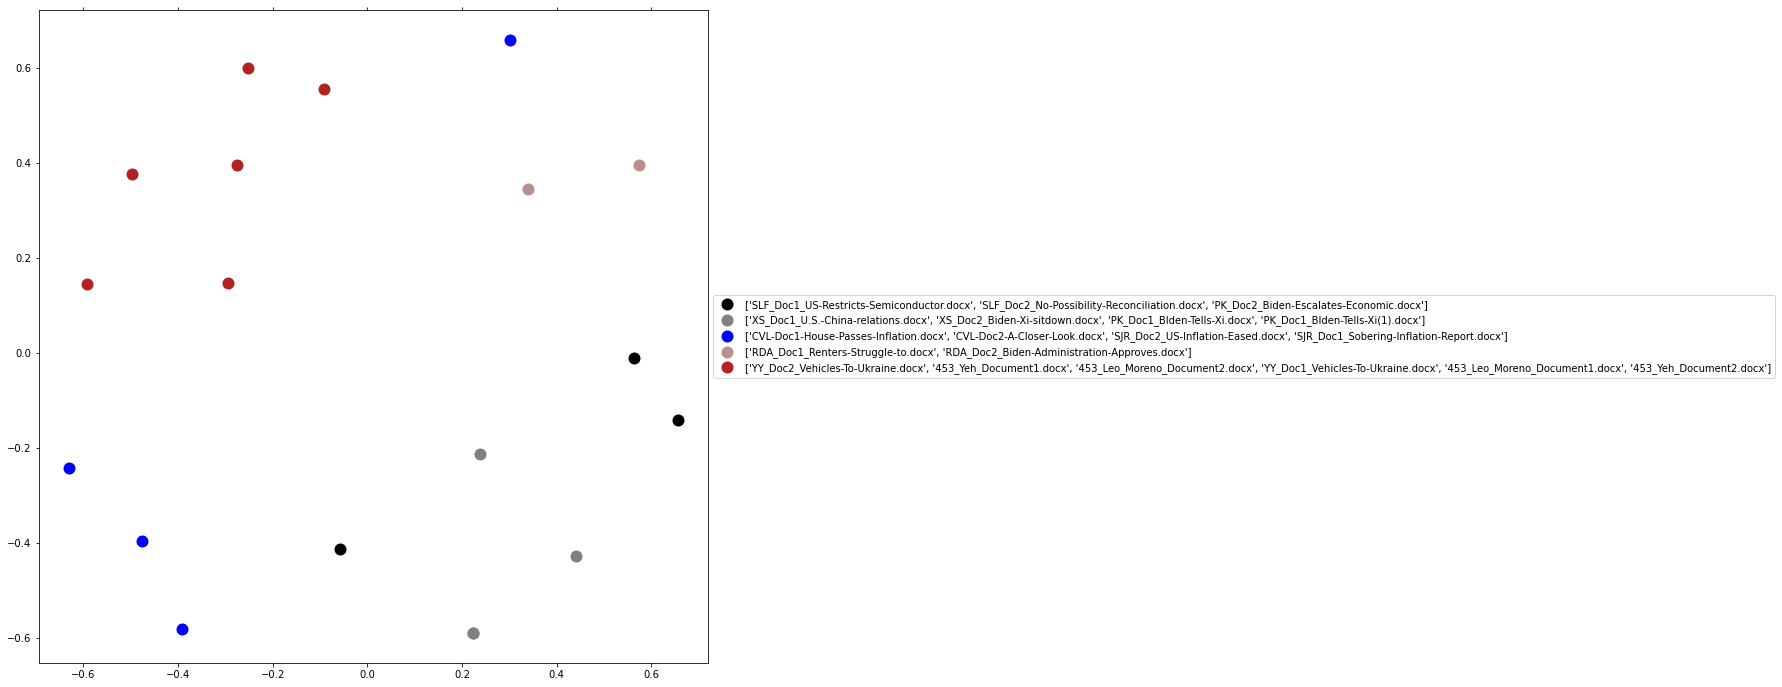

In [9]:
################
### plotting ###
################

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# will also specify `random_state` so the plot is reproducible.

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
dist = 1 - cosine_similarity(TFIDF_matrix)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

# set up colors per clusters using a dict.  number of colors must correspond to k
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick',
                  5:'red', 6:'darksalmon', 7:'sienna'}

# set up cluster names using a dict
cluster_dict=cluster_title

# create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

# group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot.
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to
# return the appropriate color/label.
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

In [10]:
# the following section of code is to run the k-means algorithm on the doc2vec outputs.
# note the differences in document clusters compared to the TFIDF matrix.

##################################
### k means clustering doc2vec ###
##################################

doc2vec_k_means=doc2vec_df.drop('title', axis=1)

k=8
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()
#terms = doc2vec_df.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': 
final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
print("Top terms per cluster:")
# sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
terms_dict=[]
# save the terms for each cluster and document to dictionaries.  
# to be used later for plotting output.

# dictionary to store clusters and respective titles
cluster_terms={}
cluster_title={}

# note doc2vec clusters will not have individual words due to the vector representation
# is based on the entire document not indvidual words. As a result, there won't be individual
# word outputs from each cluster.   
for i in range(k):
    print("Cluster %d:" % i),
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])

    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list

Top terms per cluster:
Cluster 0:
 generous
 british
 consequences
 class
 chipmakers
 drawdown
 event
 celebrate
 fresh
 grinding
Cluster 0 titles: RDA_Doc2_Biden-Administration-Approves.docx,Cluster 1:
 critical
 credit
 appropriate
 ambush
 indonesia
 gathering
 explanation
 country
 commodities
 bilateral
Cluster 1 titles: SLF_Doc1_US-Restricts-Semiconductor.docx, 453_Yeh_Document1.docx, SLF_Doc2_No-Possibility-Reconciliation.docx, CVL-Doc2-A-Closer-Look.docx, 453_Leo_Moreno_Document1.docx, 453_Yeh_Document2.docx,Cluster 2:
 global
 academic
 coercive
 humanitarian
 bring
 greenlight
 environment
 effort
 action
 highend
Cluster 2 titles: XS_Doc2_Biden-Xi-sitdown.docx,Cluster 3:
 globalization
 culmination
 hundred
 democratic
 approving
 developments
 howitzers
 areas
 defeat
 customers
Cluster 3 titles: YY_Doc1_Vehicles-To-Ukraine.docx, SJR_Doc2_US-Inflation-Eased.docx, SJR_Doc1_Sobering-Inflation-Report.docx,Cluster 4:
 commentariat
 dugin
 inequality
 generous
 better
 driving


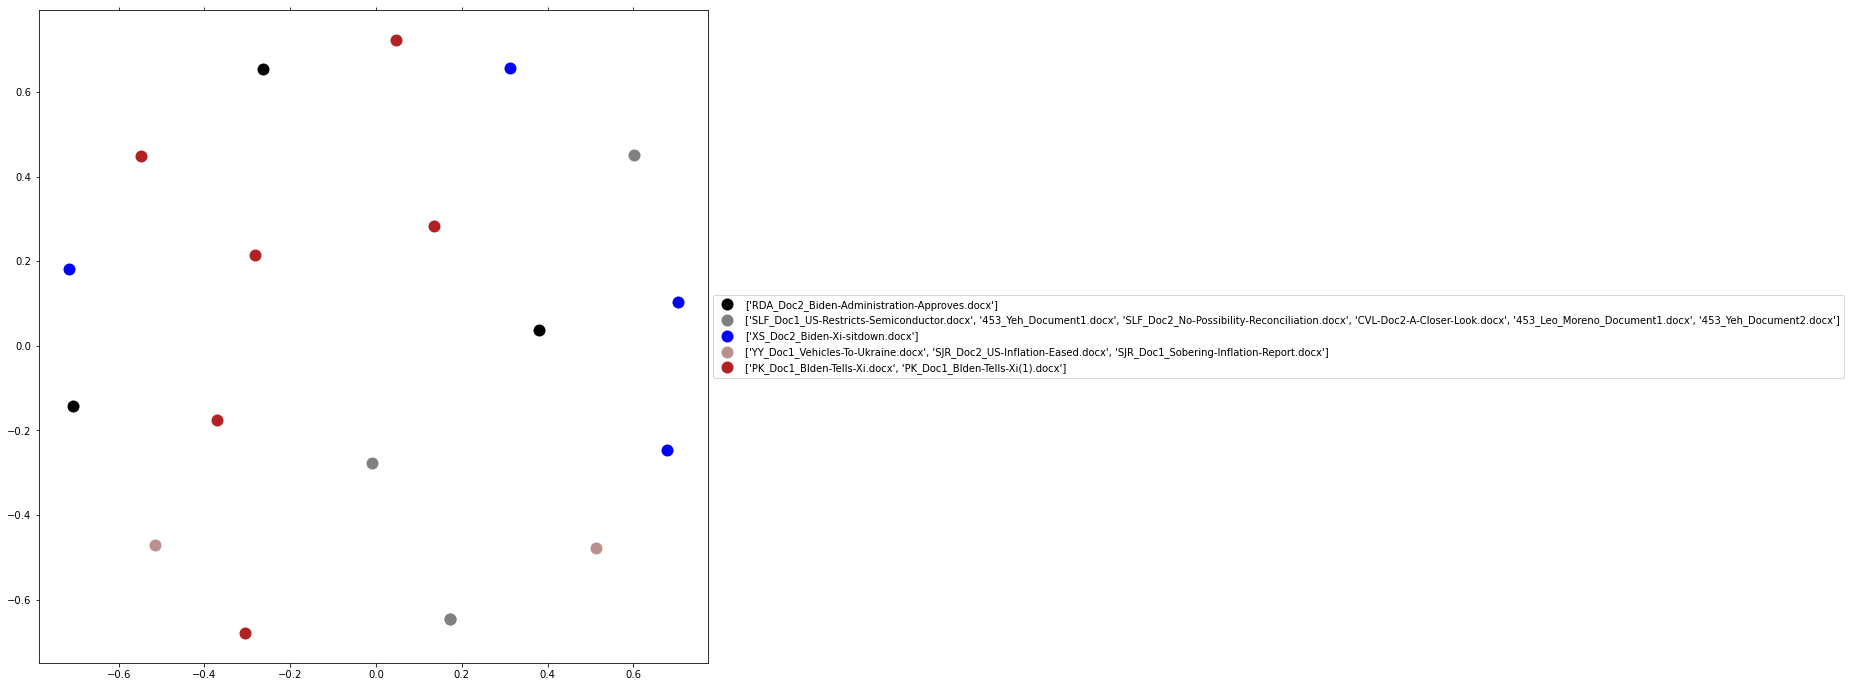

In [11]:
########################
### plotting doc2vec ###
########################

# convert two components as we're plotting points in a two-dimensional plane.
# "precomputed" because we provide a distance matrix.
# we will also specify `random_state` so the plot is reproducible.

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
dist = 1 - cosine_similarity(doc2vec_k_means)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

# set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick',
                  5:'red', 6:'darksalmon', 7:'sienna'}

# set up cluster names using a dict.  
cluster_dict=cluster_title         

# create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

# group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot.
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to
# return the appropriate color/label.
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

In [12]:
################
### lda code ###
################

# lda using bag of words
dictionary = corpora.Dictionary(processed_text)
corpus = [dictionary.doc2bow(doc) for doc in processed_text]
# ldamodel = LdaMulticore(corpus, num_topics=3, id2word=dictionary, passes=2, 
# workers=2)    
# for idx, topic in ldamodel.print_topics(-1):
    #print('Topic: {} \nWords: {}'.format(idx, topic))

# lda using Tfidf
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
ldamodel = LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, 
workers=2)    
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.003*"china" + 0.002*"restrictions" + 0.002*"tariffs" + 0.002*"trump" + 0.002*"chips" + 0.002*"semiconductors" + 0.001*"advanced" + 0.001*"trade" + 0.001*"chinese" + 0.001*"semiconductor"
Topic: 1 
Words: 0.003*"taiwan" + 0.002*"china" + 0.002*"meeting" + 0.001*"policy" + 0.001*"changed" + 0.001*"stability" + 0.001*"peace" + 0.001*"ukraine" + 0.001*"defense" + 0.001*"november"
Topic: 2 
Words: 0.001*"armoured" + 0.001*"supply" + 0.001*"german" + 0.001*"ukraine" + 0.001*"infantry" + 0.001*"counterpart" + 0.001*"supplied" + 0.001*"cleverly" + 0.001*"partners" + 0.001*"tanks"
Topic: 3 
Words: 0.002*"ukraine" + 0.001*"democrats" + 0.001*"armored" + 0.001*"climate" + 0.001*"policies" + 0.001*"package" + 0.001*"ukrainian" + 0.001*"includes" + 0.001*"cooper" + 0.001*"russia"
Topic: 4 
Words: 0.002*"charging" + 0.001*"electric" + 0.001*"vehicles" + 0.001*"ukraine" + 0.001*"infantry" + 0.001*"chargers" + 0.001*"fighting" + 0.001*"network" + 0.001*"showed" + 0.001*"report"
